In [1]:
from dataloader import CircleDataset, CircleRaw
from DETR_model import DinoDETR
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from ModelInfer import ModelInfer

In [2]:
query_embed = nn.Embedding(80, 384)
query_embed.weight.shape

torch.Size([80, 384])

In [3]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [4]:
model = DinoDETR().cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
(
    pre_idx,
    fir_img,
    fir_sgm,
    fir_bou,
    pre_img,
    pre_sgm,
    pre_bou,
    cur_img,
    cur_sgm,
    cur_bou,
) = next(iter(data_loader))
pre_idx

tensor([8])

In [6]:
model_infer = ModelInfer(raw_set, is_detr=True)

In [7]:
model_infer.infer_model(model)

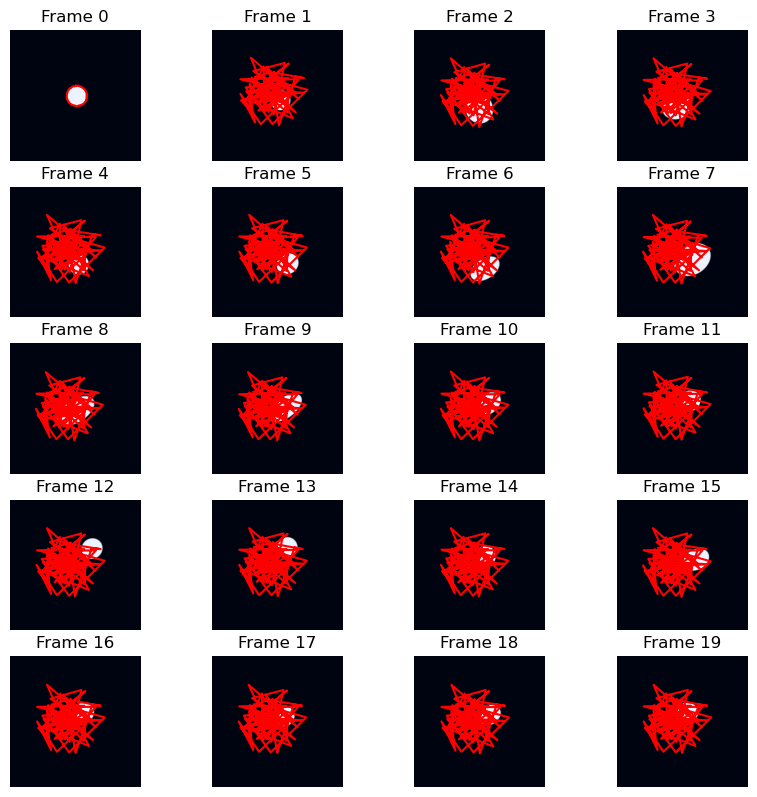

tensor(0.1709)

In [8]:
model_infer.show_infer_result(0)

In [9]:
model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
).shape

torch.Size([1, 80, 2])

In [10]:
model = DinoDETR().cuda()
ras_loss = RasLoss()
model_infer = ModelInfer(raw_set, is_detr=True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [11]:
loss_dict = {}
iou_dict = {}
interval_epochs = 50
inter_num = 47
epoch_index = 0
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 0 Loss: 0.913350826815555
Epoch 1 Loss: 0.8415205478668213
Epoch 2 Loss: 0.7975625740854364
Epoch 3 Loss: 0.735575911245848
Epoch 4 Loss: 0.7376096436851903
Epoch 5 Loss: 0.7734838630023756
Epoch 6 Loss: 0.787856472165961
Epoch 7 Loss: 0.7253035840235258
Epoch 8 Loss: 0.7401079723709508
Epoch 9 Loss: 0.7959030772510328
Epoch 10 Loss: 0.7342575443418402
Epoch 11 Loss: 0.7278520935460141
Epoch 12 Loss: 0.6537538766860962
Epoch 13 Loss: 0.7028972914344386
Epoch 14 Loss: 0.7399839445164329
Epoch 15 Loss: 0.6461254170066432
Epoch 16 Loss: 0.6367431314367997
Epoch 17 Loss: 0.580606438611683
Epoch 18 Loss: 0.6364398849637884
Epoch 19 Loss: 0.722328666009401
Epoch 20 Loss: 0.5738052129745483
Epoch 21 Loss: 0.6341419470937628
Epoch 22 Loss: 0.6686488703677529
Epoch 23 Loss: 0.6230918765068054
Epoch 24 Loss: 0.5832291276831376
Epoch 25 Loss: 0.5770513070257086
Epoch 26 Loss: 0.5203088710182592
Epoch 27 Loss: 0.4925905246483652
Epoch 28 Loss: 0.5280252004924574
Epoch 29 Loss: 0.523667363744

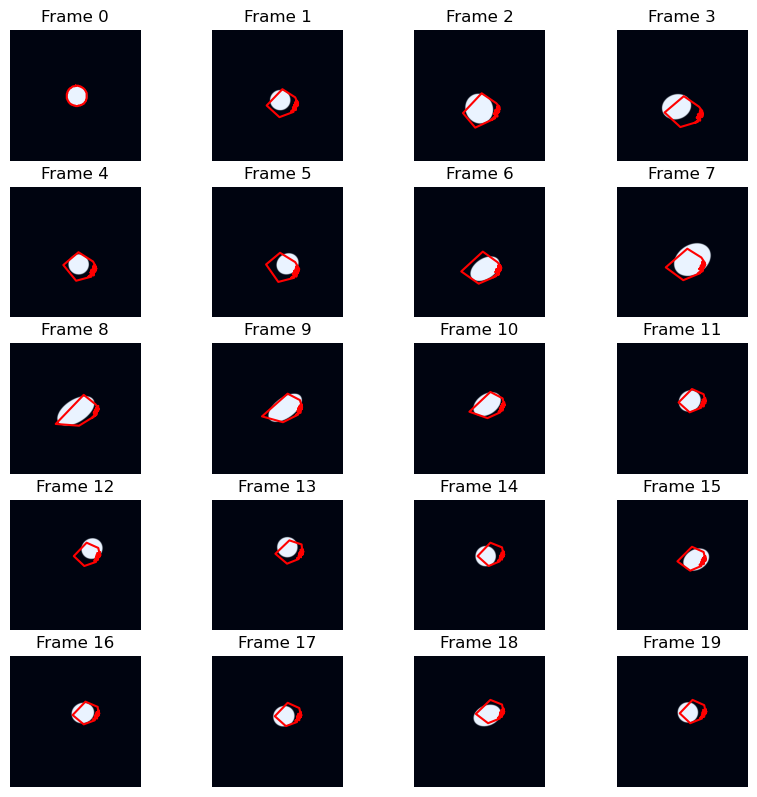

Epoch 50 Loss: 0.3567512976495843
Epoch 51 Loss: 0.326644618260233
Epoch 52 Loss: 0.3248479899607207
Epoch 53 Loss: 0.38474551313801814
Epoch 54 Loss: 0.4189783177877727
Epoch 55 Loss: 0.35202329409749883
Epoch 56 Loss: 0.3588380217552185
Epoch 57 Loss: 0.41877852929265874
Epoch 58 Loss: 0.3730915941690144
Epoch 59 Loss: 0.3039750268584804
Epoch 60 Loss: 0.3309823807917143
Epoch 61 Loss: 0.3094369580871181
Epoch 62 Loss: 0.2603372711884348
Epoch 63 Loss: 0.31237655878067017
Epoch 64 Loss: 0.24971762770100644
Epoch 65 Loss: 0.2817915866249486
Epoch 66 Loss: 0.2643561331849349
Epoch 67 Loss: 0.24582610945952565
Epoch 68 Loss: 0.27618858061338725
Epoch 69 Loss: 0.2720763651948226
Epoch 70 Loss: 0.2734525893863879
Epoch 71 Loss: 0.268692063657861
Epoch 72 Loss: 0.286741084174106
Epoch 73 Loss: 0.3681378646900779
Epoch 74 Loss: 0.34584230184555054
Epoch 75 Loss: 0.3043375579934371
Epoch 76 Loss: 0.26387379043980647
Epoch 77 Loss: 0.28527698077653585
Epoch 78 Loss: 0.2402503208110207
Epoch 7

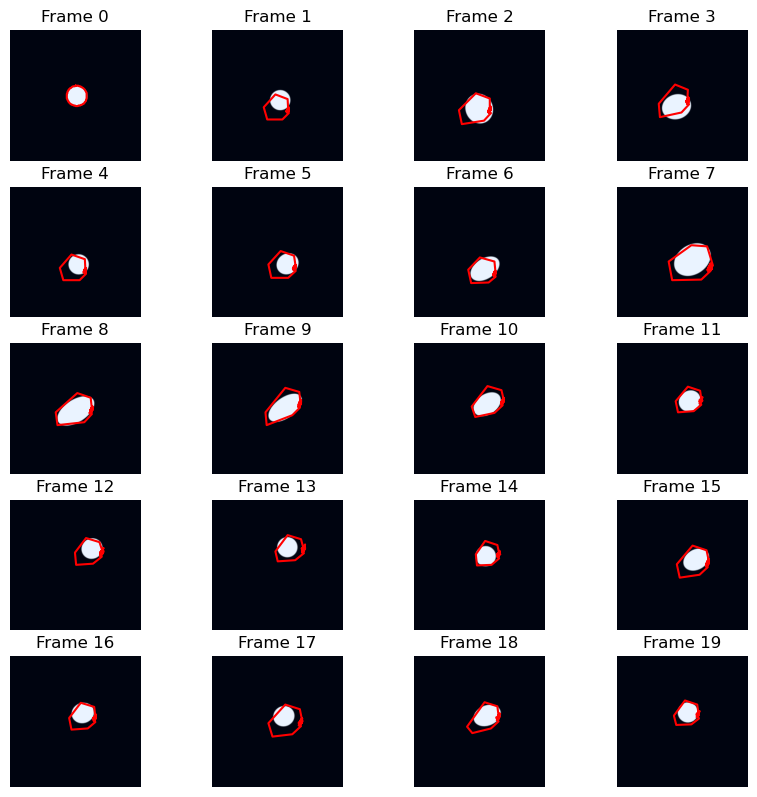

Epoch 90 Loss: 0.25565761955160843
Epoch 91 Loss: 0.2216297482189379
Epoch 92 Loss: 0.20195644152791878
Epoch 93 Loss: 0.27560988225434957
Epoch 94 Loss: 0.2234476365541157
Epoch 95 Loss: 0.19549220172982468
Epoch 96 Loss: 0.24470589349144384
Epoch 97 Loss: 0.2754956326986614
Epoch 98 Loss: 0.2329167127609253
Epoch 99 Loss: 0.21553133349669606
Epoch 100 Loss: 0.2144185273270858
Epoch 101 Loss: 0.20751921126717016
Epoch 102 Loss: 0.2137853032664249
Epoch 103 Loss: 0.2267028250192341
Epoch 104 Loss: 0.18811319062584325
Epoch 105 Loss: 0.20195194608286807
Epoch 106 Loss: 0.19691634805578934
Epoch 107 Loss: 0.20426139078642191
Epoch 108 Loss: 0.2326669881218358
Epoch 109 Loss: 0.20013217235866346
Epoch 110 Loss: 0.16399270923514114
Epoch 111 Loss: 0.1740333312436154
Epoch 112 Loss: 0.24461917814455533
Epoch 113 Loss: 0.2060968781772413
Epoch 114 Loss: 0.1918620467185974
Epoch 115 Loss: 0.1899310601385016
Epoch 116 Loss: 0.2041077833426626
Epoch 117 Loss: 0.17504298373272545
Epoch 118 Loss:

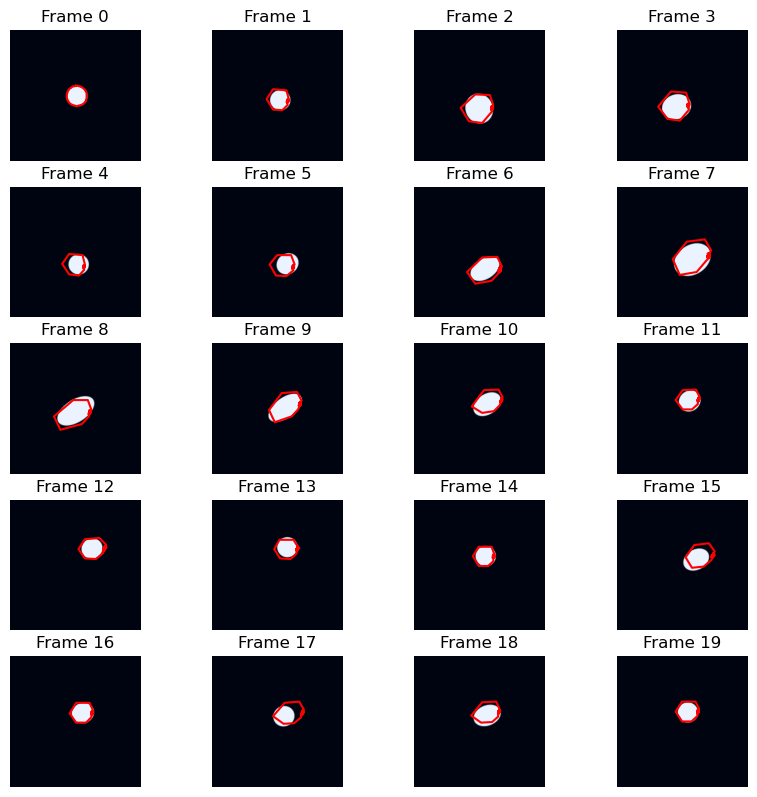

Epoch 120 Loss: 0.14883848240501002
Epoch 121 Loss: 0.14014016640813728
Epoch 122 Loss: 0.14141632694947093
Epoch 123 Loss: 0.15688681602478027
Epoch 124 Loss: 0.14804380818417198
Epoch 125 Loss: 0.19326223825153552
Epoch 126 Loss: 0.18394514447764346
Epoch 127 Loss: 0.18338782222647415
Epoch 128 Loss: 0.18600785104851975
Epoch 129 Loss: 0.15929455819882846
Epoch 130 Loss: 0.1723644356978567
Epoch 131 Loss: 0.16437061209427684
Epoch 132 Loss: 0.19866512637389333
Epoch 133 Loss: 0.1949273943901062
Epoch 134 Loss: 0.1577668880161486
Epoch 135 Loss: 0.15254545211791992
Epoch 136 Loss: 0.1813492461254722
Epoch 137 Loss: 0.1780651901897631
Epoch 138 Loss: 0.17584322628222013
Epoch 139 Loss: 0.1670267142747578
Epoch 140 IOU: 0.7036367654800415


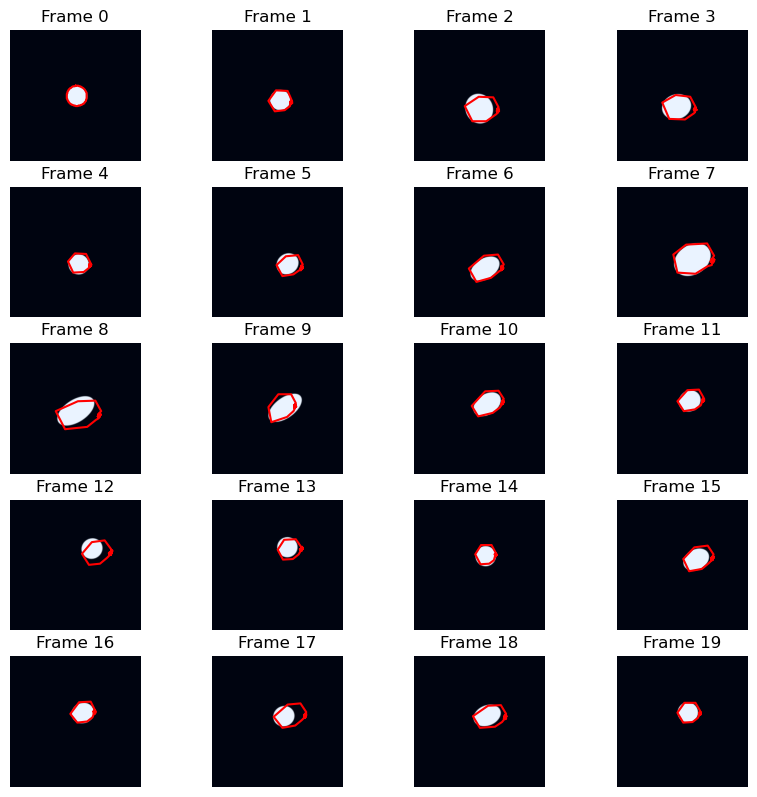

Epoch 140 Loss: 0.19838153061113858
Epoch 141 Loss: 0.21100072484267385
Epoch 142 Loss: 0.23964914208964297
Epoch 143 Loss: 0.1935797835651197
Epoch 144 Loss: 0.16855307629233912
Epoch 145 Loss: 0.1926455121291311
Epoch 146 Loss: 0.15204461311039172
Epoch 147 Loss: 0.1696330465768513
Epoch 148 Loss: 0.1493349639992965


KeyboardInterrupt: 

In [12]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            # pre_sgm = model_infer.get_segement(pre_idx)
            # pre_sgm = pre_sgm.unsqueeze(0)
            optimizer.zero_grad()
            pred_bou = model(
                fir_img.cuda(),
                fir_sgm.cuda(),
                pre_img.cuda(),
                pre_sgm.cuda(),
                cur_img.cuda(),
            )
            loss = ras_loss(pred_bou, cur_sgm.cuda())
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        loss_dict[epoch_index] = mean_loss
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_infer_iou(0)
    iou_dict[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IOU: {total_iou}")
    model_infer.show_infer_result(0)
    if interval_epochs > 50:
        interval_epochs = 50
        break
    if interval_epochs > 20:
        interval_epochs -= 10
            
            